In [138]:
import pandas as pd
import numpy as np
import os
import tsfresh
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import tensorflow as tf
import seaborn as sns

import os

import matplotlib.pyplot as plt

# keras goodies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv1D, Dropout, MaxPooling1D, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import metrics as kmetrics
import tensorflow.keras.backend as K

## Getting the data

Before you run this, make sure that you have generated a sliding_windows file by running 01_sliding_windows.

In [139]:
data_path = '../data/'

In [140]:
final_sliding_windows = pd.read_csv(data_path + '/sliding_windows_Thingy_smallest20_size20_step20.csv')
# final_sliding_windows = pd.read_csv(data_path + '/sliding_windows_Respeck_smallest20_size20_step20.csv')

In [141]:
def plot_by_id(df, i): 
    plot_recording = df[df['recording_id'] == i]
    plot_recording = plot_recording.reset_index()
    plt.plot(plot_recording.index, plot_recording['accel_x'])
    plt.plot(plot_recording.index, plot_recording['accel_y'])
    plt.plot(plot_recording.index, plot_recording['accel_z'])
     
# plot_by_id(final_sliding_windows, 'Respeck_s1865457_Falling on the back_30-09-2021_11-53-32')

## Some definitions

### Prepping the CNN model

In [142]:
def prep_cnn():
    print("Prepping CNN...")
    
    filters = 64
    kernel_size = 3
    n_features = 6
    activation ='relu'
    n_classes = len(class_labels)
    window_size = 20
    #filters = [3, 7, 11]
    
    tf.random.set_seed(1)

    model = Sequential()

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear', 
                     input_shape=(window_size, n_features)))
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='linear'))
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    #model.summary()
    
    model.compile(
    optimizer=optimizers.Adam(lr=0.001),
    loss='categorical_crossentropy',
    metrics = ['accuracy'])
    
    print("CNN prepped.")
    
    return model

### Format the input

Format data into windows - make (window_size,6) inputs

In [143]:
columns_of_interest = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

In [144]:
class_labels = {
    'Sitting': 0,
    'Sitting bent forward': 1,
    'Sitting bent backward': 2,
    'Standing': 3,
    'Lying down left': 4,
    'Lying down right': 5,
    'Lying down on stomach': 6,
    'Lying down on back': 7,
    'Walking at normal speed': 8,
    'Running': 9,
    'Climbing stairs': 10,
    'Descending stairs': 11,
    'Desk work': 12,
    'Movement': 13,
    'Falling on knees': 14,
    'Falling on the back': 15,
    'Falling on the left': 16,
    'Falling on the right': 17
}

In [156]:
def format_data(X_train_full, y_train_full, X_test_full, y_test_full):
    
    print("Formating data...")
    # Keep only the classes of interest
#     X_train_full = X_train_full[y_train_full['activity_type'].isin(class_labels.keys())]
#     X_test_full = X_test_full[y_test_full['activity_type'].isin(class_labels.keys())]
#     y_train_full = y_train_full[y_train_full['activity_type'].isin(class_labels.keys())]
#     y_test_full = y_test_full[y_test_full['activity_type'].isin(class_labels.keys())]

    # Create the y ones
    y_train = y_train_full.groupby("window_id")[['activity_type']].agg(np.min).replace(class_labels)['activity_type'].values
    y_test = y_test_full.groupby("window_id")[['activity_type']].agg(np.min).replace(class_labels)['activity_type'].values
    y_train = np.asarray(pd.get_dummies(y_train), dtype=np.float32)
    y_test = np.asarray(pd.get_dummies(y_test), dtype=np.float32)
    
    X_train = []
    X_test = []

    for window_id, group in X_train_full.groupby('window_id'):
        #print(f"window_id = {window_id}")

        shape = group[columns_of_interest].values.shape
        #print(f"shape = {shape}")
        if shape == (20,6):
            X_train.append(group[columns_of_interest].values)

    for window_id, group in X_test_full.groupby('window_id'):
        #print(f"window_id = {window_id}")

        shape = group[columns_of_interest].values.shape
        #print(f"shape = {shape}")

        X_test.append(group[columns_of_interest].values)

    X_train = np.asarray(X_train)#, dtype=object)
    X_test = np.asarray(X_test)#, dtype=object)
    
    print(np.shape(X_train))
    print(np.shape(X_test))

    print(np.shape(y_train))
    print(np.shape(y_test))
    
    print("Data formatted.")
    return X_train, y_train, X_test, y_test

In [158]:
def format_all_data(X_train_full, y_train_full):
    # to be used when we only want a training set not test set
    
    print("Formating data...")
    # Keep only the classes of interest
#     X_train_full = X_train_full[y_train_full['activity_type'].isin(class_labels.keys())]
#     y_train_full = y_train_full[y_train_full['activity_type'].isin(class_labels.keys())]

    # Create the y ones
    y_train = y_train_full.groupby("window_id")[['activity_type']].agg(np.min).replace(class_labels)['activity_type'].values
    y_train = np.asarray(pd.get_dummies(y_train), dtype=np.float32)
    
    X_train = []

    for window_id, group in X_train_full.groupby('window_id'):
        #print(f"window_id = {window_id}")

        shape = group[columns_of_interest].values.shape
        #print(f"shape = {shape}")
        if shape == (20,6):
            X_train.append(group[columns_of_interest].values)

    X_train = np.asarray(X_train)#, dtype=object)
    
    print(np.shape(X_train))
    print(np.shape(y_train))
    
    print("Data formatted.")
    return X_train, y_train

### Accuracy of the subset

In [146]:
 groups = {
     'Sitting/Standing': [0,1,2,3,12], # including desk work
     'Lying': [4,5,6,7],
     'Walking': [8,10,11,13], # I include up and down stairs in this one + movement
     'Running': [9],
     'Falling': [14,15,16,17]
 }

In [147]:
def group_y(y):
    grouped_y = []
    for yy in y:
        group = [i for i,v in enumerate(groups.values()) if yy in v][0]
        grouped_y.append(group)
    return grouped_y

## Train a baseline model 

In [148]:
# split data into training and test sets (split by subject)

subjects = final_sliding_windows['subject_id'].unique()

train_subjects, test_subjects = train_test_split(subjects, test_size=0.2, train_size=0.8)

X_train_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(train_subjects)][['window_id'] + columns_of_interest]
y_train_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(train_subjects)][['window_id'] + ['activity_type']]

X_test_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(test_subjects)][['window_id'] + columns_of_interest]
y_test_full = final_sliding_windows[final_sliding_windows['subject_id'].isin(test_subjects)][['window_id'] + ['activity_type']]


In [149]:
# format the data
X_train, y_train, X_test, y_test = format_data(X_train_full, y_train_full, X_test_full, y_test_full)
   
# prepare the CNN
model = prep_cnn()

Formating data...
(23929, 20, 6)
(6338, 20, 6)
(23929, 18)
(6338, 18)
Data formatted.
Prepping CNN...
CNN prepped.


In [150]:
# train the model 
model.fit(X_train, y_train, batch_size=100, epochs=10)

Epoch 1/10
240/240 [==============================] - 12s 43ms/step - loss: 2.0602 - accuracy: 0.2836
Epoch 2/10
240/240 [==============================] - 9s 36ms/step - loss: 1.2130 - accuracy: 0.5784
Epoch 3/10
240/240 [==============================] - 10s 40ms/step - loss: 1.0430 - accuracy: 0.6206
Epoch 4/10
240/240 [==============================] - 8s 35ms/step - loss: 0.9653 - accuracy: 0.6428
Epoch 5/10
240/240 [==============================] - 8s 32ms/step - loss: 0.8926 - accuracy: 0.6702
Epoch 6/10
240/240 [==============================] - 8s 34ms/step - loss: 0.8387 - accuracy: 0.6867
Epoch 7/10
240/240 [==============================] - 8s 35ms/step - loss: 0.8158 - accuracy: 0.6900
Epoch 8/10
240/240 [==============================] - 8s 35ms/step - loss: 0.7667 - accuracy: 0.7070
Epoch 9/10
240/240 [==============================] - 8s 35ms/step - loss: 0.7314 - accuracy: 0.7219
Epoch 10/10
240/240 [==============================] - 8s 34ms/step - loss: 0.7164 - accu

In [151]:
# test the model
y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

In [152]:
print("*" * 80)
print("Classification report")
print("*" * 80)
print(classification_report(y_true_labels, y_pred_labels))

********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       377
           1       0.24      0.56      0.33       340
           2       1.00      0.11      0.20       344
           3       0.90      0.89      0.90       344
           4       0.80      0.89      0.84       355
           5       0.70      0.78      0.74       340
           6       0.99      0.90      0.95       383
           7       0.54      0.61      0.57       368
           8       0.79      0.73      0.76       378
           9       0.93      0.86      0.90       377
          10       0.78      0.74      0.76       373
          11       0.72      0.73      0.73       368
          12       0.26      0.21      0.23       348
          13       0.50      0.62      0.55       385
     

In [153]:
confusion_matrix = tf.math.confusion_matrix(
    y_true_labels, y_pred_labels, num_classes=None, weights=None, dtype=tf.dtypes.int32,
    name=None
)

<AxesSubplot:>

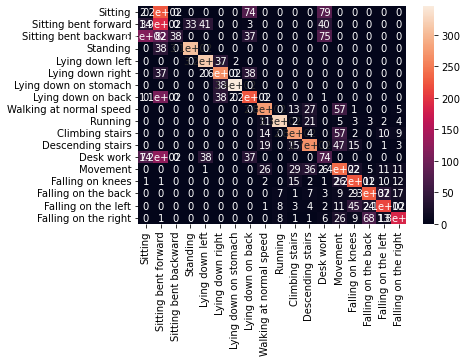

In [154]:
sns.heatmap(confusion_matrix, annot=True, xticklabels=class_labels.keys(), yticklabels=class_labels.keys())

In [155]:
# compute accuracy of the subset of activities 

grouped_y_true_labels = group_y(y_true_labels)
grouped_y_pred_labels = group_y(y_pred_labels)

print("*" * 80)
print("Classification report")
print("*" * 80)
print(classification_report(grouped_y_true_labels, grouped_y_pred_labels))

********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      1753
           1       0.85      0.90      0.87      1446
           2       0.90      0.93      0.92      1504
           3       0.93      0.86      0.90       377
           4       0.91      0.88      0.90      1258

    accuracy                           0.89      6338
   macro avg       0.90      0.89      0.89      6338
weighted avg       0.89      0.89      0.89      6338



## Train baseline model on ALL data

In [161]:
X = final_sliding_windows[['window_id'] + columns_of_interest]
y = final_sliding_windows[['window_id'] + ['activity_type']]

# format the data
X_train, y_train = format_all_data(X, y)
   
# prepare the CNN
model = prep_cnn()

Formating data...
(30267, 20, 6)
(30267, 18)
Data formatted.
Prepping CNN...
CNN prepped.


In [162]:
# train the model 
model.fit(X_train, y_train, batch_size=100, epochs=10)

Epoch 1/10
303/303 [==============================] - 12s 33ms/step - loss: 1.9613 - accuracy: 0.3178
Epoch 2/10
303/303 [==============================] - 10s 33ms/step - loss: 1.1631 - accuracy: 0.5905
Epoch 3/10
303/303 [==============================] - 10s 34ms/step - loss: 1.0183 - accuracy: 0.6290
Epoch 4/10
303/303 [==============================] - 11s 37ms/step - loss: 0.9227 - accuracy: 0.6596
Epoch 5/10
303/303 [==============================] - 10s 34ms/step - loss: 0.8764 - accuracy: 0.6773
Epoch 6/10
303/303 [==============================] - 10s 32ms/step - loss: 0.8198 - accuracy: 0.6862
Epoch 7/10
303/303 [==============================] - 10s 34ms/step - loss: 0.7854 - accuracy: 0.7047
Epoch 8/10
303/303 [==============================] - 10s 32ms/step - loss: 0.7692 - accuracy: 0.7105
Epoch 9/10
303/303 [==============================] - 10s 33ms/step - loss: 0.7403 - accuracy: 0.7200
Epoch 10/10
303/303 [==============================] - 10s 34ms/step - loss: 0.706

## Leave-One-Subject-Out Cross Validation

In [90]:
loocv = LeaveOneGroupOut()
# group by subject id so that one subject is left out each time
groups = final_sliding_windows['subject_id']

X = final_sliding_windows[['window_id'] + columns_of_interest]
y = final_sliding_windows[['window_id'] + ['activity_type']]

# how many different subjects
loocv.get_n_splits(X, y, groups)

48

In [99]:
y_pred_labels = np.empty(shape=(0,))
y_true_labels = np.empty(shape=(0,))

# this gives a train/test split that leaves one subject out in each iteration
for i, (train_index, test_index) in enumerate(loocv.split(X, y, groups)):
    print("Starting iteration " + str(i))
    
    X_train_full, X_test_full = X.iloc[train_index], X.iloc[test_index]
    y_train_full, y_test_full = y.iloc[train_index], y.iloc[test_index]
    
    X_train, y_train, X_test, y_test = format_data(X_train_full, y_train_full, X_test_full, y_test_full)
    
    model = prep_cnn()
    
    print("Training...")
    # todo change no. epochs
    model.fit(X_train, y_train, batch_size=100, epochs=3)
    
    # stats
    y_pred_ohe = model.predict(X_test)
    y_pred_labels = np.concatenate([y_pred_labels, np.argmax(y_pred_ohe, axis=1)])
    y_true_labels = np.concatenate([y_true_labels, np.argmax(y_test, axis=1)])
    
    print(y_pred_labels.shape)
    print(y_true_labels.shape)
    
print("*" * 80)
print("Classification report")
print("*" * 80)
print(classification_report(y_true_labels, y_pred_labels))
    

Formating data...
Data formatted.
Prepping CNN...
CNN prepped.
Training...
Epoch 1/3
297/297 [==============================] - 12s 33ms/step - loss: 1.9839 - accuracy: 0.3148
Epoch 2/3
297/297 [==============================] - 10s 34ms/step - loss: 1.1595 - accuracy: 0.5865
Epoch 3/3
297/297 [==============================] - 10s 33ms/step - loss: 1.0098 - accuracy: 0.6341
(656,)
(656,)
Formating data...
Data formatted.
Prepping CNN...
CNN prepped.
Training...
Epoch 1/3
297/297 [==============================] - 12s 35ms/step - loss: 1.9894 - accuracy: 0.3104
Epoch 2/3
297/297 [==============================] - 11s 36ms/step - loss: 1.1660 - accuracy: 0.5836
Epoch 3/3
297/297 [==============================] - 11s 37ms/step - loss: 1.0215 - accuracy: 0.6336
(1312,)
(1312,)
Formating data...
Data formatted.
Prepping CNN...
CNN prepped.
Training...
Epoch 1/3
297/297 [==============================] - 12s 34ms/step - loss: 1.9766 - accuracy: 0.3074
Epoch 2/3
297/297 [===================

297/297 [==============================] - 16s 53ms/step - loss: 1.0007 - accuracy: 0.6400
(13452,)
(13452,)
Formating data...
Data formatted.
Prepping CNN...
CNN prepped.
Training...
Epoch 1/3
297/297 [==============================] - 13s 38ms/step - loss: 1.9526 - accuracy: 0.3139
Epoch 2/3
297/297 [==============================] - 11s 38ms/step - loss: 1.1508 - accuracy: 0.5934
Epoch 3/3
297/297 [==============================] - 11s 36ms/step - loss: 1.0279 - accuracy: 0.6348
(14097,)
(14097,)
Formating data...
Data formatted.
Prepping CNN...
CNN prepped.
Training...
Epoch 1/3
297/297 [==============================] - 13s 38ms/step - loss: 1.9501 - accuracy: 0.3198
Epoch 2/3
297/297 [==============================] - 13s 43ms/step - loss: 1.1640 - accuracy: 0.5906
Epoch 3/3
297/297 [==============================] - 14s 47ms/step - loss: 1.0063 - accuracy: 0.6383
(14725,)
(14725,)
Formating data...
Data formatted.
Prepping CNN...
CNN prepped.
Training...
Epoch 1/3
296/296 [=====

297/297 [==============================] - 11s 33ms/step - loss: 1.9622 - accuracy: 0.3163
Epoch 2/3
297/297 [==============================] - 9s 29ms/step - loss: 1.1600 - accuracy: 0.5910
Epoch 3/3
297/297 [==============================] - 9s 29ms/step - loss: 1.0264 - accuracy: 0.6342
(26360,)
(26360,)
Formating data...
Data formatted.
Prepping CNN...
CNN prepped.
Training...
Epoch 1/3
297/297 [==============================] - 12s 36ms/step - loss: 1.9748 - accuracy: 0.3152
Epoch 2/3
297/297 [==============================] - 9s 30ms/step - loss: 1.1732 - accuracy: 0.5898
Epoch 3/3
297/297 [==============================] - 10s 32ms/step - loss: 1.0175 - accuracy: 0.6339
(26995,)
(26995,)
Formating data...
Data formatted.
Prepping CNN...
CNN prepped.
Training...
Epoch 1/3
297/297 [==============================] - 11s 30ms/step - loss: 1.9613 - accuracy: 0.3130
Epoch 2/3
297/297 [==============================] - 9s 31ms/step - loss: 1.1634 - accuracy: 0.5857
Epoch 3/3
297/297 [=

In [101]:
confusion_matrix = tf.math.confusion_matrix(
    y_true_labels, y_pred_labels, num_classes=None, weights=None, dtype=tf.dtypes.int32,
    name=None
)

<AxesSubplot:>

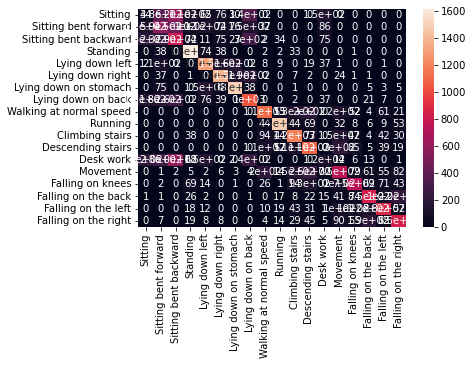

In [102]:
sns.heatmap(confusion_matrix, annot=True, xticklabels=class_labels.keys(), yticklabels=class_labels.keys())

In [105]:
grouped_y_true_labels = group_y(y_true_labels)
grouped_y_pred_labels = group_y(y_pred_labels)

In [106]:
print("*" * 80)
print("Classification report")
print("*" * 80)
print(classification_report(grouped_y_true_labels, grouped_y_pred_labels))

********************************************************************************
Classification report
********************************************************************************
              precision    recall  f1-score   support

           0       0.86      0.78      0.82      8883
           1       0.77      0.86      0.81      7229
           2       0.84      0.86      0.85      6871
           3       0.85      0.85      0.85      1752
           4       0.84      0.81      0.83      5532

    accuracy                           0.83     30267
   macro avg       0.83      0.83      0.83     30267
weighted avg       0.83      0.83      0.83     30267



### Save a test instance

In [41]:
for i in range(5):
    print(y_test[i])
    #np.savetxt('data/test_instance_window20_' + str(i) + '.txt', X_test[i])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [42]:
for i in np.arange(15,20):
    print(y_test[i])
    np.savetxt('data/test_instance_window20_' + str(i) + '.txt', X_test[i])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


## Save to file and convert to tflite

In [123]:
# Saving the model to file
model_name = 'cnn_simple_full_thingy'

export_dir = 'models\\' + model_name
tf.saved_model.save(model,export_dir)

# Convert the saved tensorflow model to tensorflow lite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

# Save the tensorflow lite model to file
import pathlib
tflite_model_file = pathlib.Path('models/' + model_name + '.tflite')
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: models\cnn_simple_full_thingy\assets


473324